In [133]:
import xarray as xr
import os
import pandas as pd
import numpy as np
import functions.eddy_feedback as ef

import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp

# Bootstrapped

In [134]:
def load_bootstrap_results(folder, season):
    results = {}
    for file_name in os.listdir(folder):
        if file_name.endswith(f'_{season}_efp_values.npy') or file_name.endswith(f'_{season}_efp_mixed-freq.npy'):
            model = file_name.split('_')[0]
            if model == 'JRA55':
                period = file_name.split('_')[1]
                model = f'JRA55 ({period})'
            efp_values = np.load(os.path.join(folder, file_name))
            results[model] = efp_values
    return results

def create_bootstrap_df(results):
    df = pd.DataFrame({
        'Model': np.repeat(list(results.keys()), [len(v) for v in results.values()]),
        'EFP': np.concatenate(list(results.values()))
    })
    model_order = sorted([m for m in results if m.split(' ')[0] != 'JRA55']) + ['JRA55 (1979-2016)']
    df['Model'] = pd.Categorical(df['Model'], categories=model_order, ordered=True)
    return df

def compute_mean_std(df):
    mean = df.groupby('Model', observed=True)['EFP'].mean()
    std = df.groupby('Model', observed=True)['EFP'].std()
    return mean, std

def build_summary_df(mean_nh, std_nh, mean_sh, std_sh):
    return pd.DataFrame({
        'Model': mean_nh.index,
        'EFP_NH': mean_nh.values,
        'EFP_SH': mean_sh.values,
        'EFP_NH_STD': std_nh.values,
        'EFP_SH_STD': std_sh.values
    })

In [135]:
data_folder = '/home/links/ct715/eddy_feedback/chapter1/daily_efp/bootstrap/data'
plot_folder = '/home/links/ct715/eddy_feedback/chapter1/daily_efp/bootstrap/plots'
frequencies = ['daily', 'mixed-freq']  # change as needed

summary_dict = {}

for freq in frequencies:
    freq_path = os.path.join(data_folder, freq)
    bootstrap_djf = load_bootstrap_results(freq_path, 'djf')
    bootstrap_jas = load_bootstrap_results(freq_path, 'jas')
    
    df_djf = create_bootstrap_df(bootstrap_djf)
    df_jas = create_bootstrap_df(bootstrap_jas)
    
    mean_djf, std_djf = compute_mean_std(df_djf)
    mean_jas, std_jas = compute_mean_std(df_jas)
    
    summary_df = build_summary_df(mean_djf, std_djf, mean_jas, std_jas)
    summary_dict[freq] = summary_df

In [136]:
# summary_dict['daily'] = summary_dict['daily'][summary_dict['daily']['Model'] != 'JRA55 (1979-2016)'].reset_index(drop=True)
# summary_dict['daily']['Model'] = summary_dict['daily']['Model'].cat.remove_unused_categories()
# summary_dict['daily']

In [137]:
mixed_freq = summary_dict['mixed-freq'][summary_dict['mixed-freq']['Model'].isin(summary_dict['daily']['Model'])].reset_index(drop=True)
mixed_freq['Model'] = mixed_freq['Model'].cat.remove_unused_categories()
mixed_freq

,Model,EFP_NH,EFP_SH,EFP_NH_STD,EFP_SH_STD
0,AWI-CM-1-1-MR,0.023419,0.020589,0.010246,0.009146
1,CNRM-CM6-1,0.243572,0.210495,0.017025,0.013023
2,CanESM5,0.426731,0.461174,0.017719,0.017379
3,FGOALS-f3-L,0.241206,0.133865,0.025810,0.015638
4,HadGEM3-GC31-LL,0.277431,0.298766,0.027004,0.028440
5,HadGEM3-GC31-MM,0.314640,0.301144,0.016933,0.012442
6,IPSL-CM6A-LR,0.274350,0.197857,0.021296,0.015555
7,MIROC6,0.225154,0.327358,0.028358,0.025656
8,JRA55 (1979-2016),0.449022,0.361631,0.055803,0.036637


In [138]:
# colours
from pypalettes import load_cmap
cmap = load_cmap("Cross")
models = mixed_freq['Model'].unique()
colors = [cmap(i / (len(models) - 1)) for i in range(len(models))]
palette = dict(zip(models, colors))

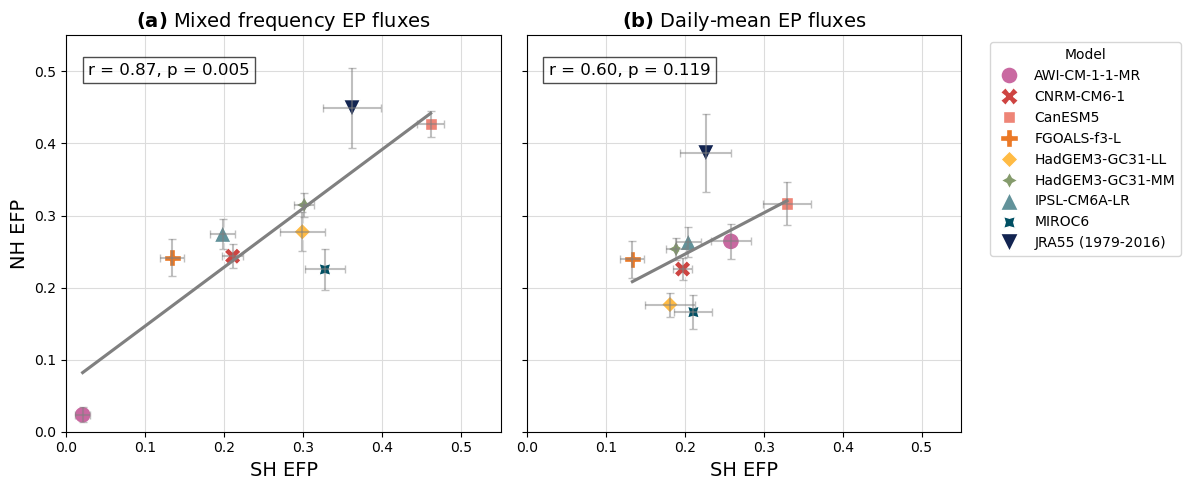

In [139]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

# Panel (a)
sns.regplot(ax=axes[0], data=mixed_freq, x='EFP_SH', y='EFP_NH',
            scatter_kws={'color': 'white'}, line_kws={"color": "gray"}, ci=None)
axes[0].errorbar(
    mixed_freq['EFP_SH'], mixed_freq['EFP_NH'],
    xerr=mixed_freq['EFP_SH_STD'], yerr=mixed_freq['EFP_NH_STD'],
    fmt='none', ecolor='gray', alpha=0.5, capsize=3
)
sns.scatterplot(ax=axes[0], data=mixed_freq, x='EFP_SH', y='EFP_NH',
                hue='Model', style='Model', s=150, palette=palette)

corr_set = mixed_freq[mixed_freq['Model'] != 'JRA55 (1979-2016)']
r, p = sp.stats.pearsonr(x=corr_set['EFP_NH'], y=corr_set['EFP_SH'])
axes[0].text(0.05, 0.9, f"r = {r:.2f}, p = {p:.3f}", transform=axes[0].transAxes,
             bbox=dict(facecolor="white", alpha=0.7), fontsize=12)

axes[0].set_xlabel('SH EFP', fontsize=14)
axes[0].set_ylabel('NH EFP', fontsize=14)
axes[0].set_xlim(0, 0.55)
axes[0].set_ylim(0, 0.55)
axes[0].set_title('$\\bf{(a)}$ Mixed frequency EP fluxes', fontsize=14)
axes[0].legend_.remove()
axes[0].grid(visible=True, color='gainsboro')
axes[0].set_axisbelow(True)

# Panel (b)
sns.regplot(ax=axes[1], data=summary_dict['daily'], x='EFP_SH', y='EFP_NH',
            scatter_kws={'color': 'white'}, line_kws={"color": "gray"}, ci=None)
axes[1].errorbar(
    summary_dict['daily']['EFP_SH'], summary_dict['daily']['EFP_NH'],
    xerr=summary_dict['daily']['EFP_SH_STD'], yerr=summary_dict['daily']['EFP_NH_STD'],
    fmt='none', ecolor='gray', alpha=0.5, capsize=3
)
sns.scatterplot(ax=axes[1], data=summary_dict['daily'], x='EFP_SH', y='EFP_NH',
                hue='Model', style='Model', s=150, palette=palette)

corr_set = summary_dict['daily'][summary_dict['daily']['Model'] != 'JRA55 (1979-2016)']
r, p = sp.stats.pearsonr(x=corr_set['EFP_NH'], y=corr_set['EFP_SH'])
axes[1].text(0.05, 0.9, f"r = {r:.2f}, p = {p:.3f}", transform=axes[1].transAxes,
             bbox=dict(facecolor="white", alpha=0.7), fontsize=12)

axes[1].set_xlabel('SH EFP', fontsize=14)
axes[1].set_ylabel('')  # no label on right subplot
axes[1].set_xlim(0, 0.55)
axes[1].set_ylim(0, 0.55)
axes[1].set_title('$\\bf{(b)}$ Daily-mean EP fluxes', fontsize=14)
axes[1].legend_.remove()
axes[1].grid(visible=True, color='gainsboro')
axes[1].set_axisbelow(True)

# Move legend outside the left panel now
axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Model')

plt.tight_layout()

save_path = '/home/links/ct715/eddy_feedback/chapter1/zz_paper_plots'
# plt.savefig(os.path.join(save_path, 'sub-daily_vs_daily.png'), bbox_inches='tight')
plt.show()


# Fabricate AWI and MIROC

:warning: incorrect error bars for AWI :warning:

In [140]:
# df.loc[df['Model'] == 'CNRM-CM6-1', ['column1', 'column2']] = [new_val1, new_val2]

mixed_freq.loc[mixed_freq['Model'] == "AWI-CM-1-1-MR", ['EFP_NH', 'EFP_SH']] = [0.3724, 0.4354]
mixed_freq

,Model,EFP_NH,EFP_SH,EFP_NH_STD,EFP_SH_STD
0,AWI-CM-1-1-MR,0.372400,0.435400,0.010246,0.009146
1,CNRM-CM6-1,0.243572,0.210495,0.017025,0.013023
2,CanESM5,0.426731,0.461174,0.017719,0.017379
3,FGOALS-f3-L,0.241206,0.133865,0.025810,0.015638
4,HadGEM3-GC31-LL,0.277431,0.298766,0.027004,0.028440
5,HadGEM3-GC31-MM,0.314640,0.301144,0.016933,0.012442
6,IPSL-CM6A-LR,0.274350,0.197857,0.021296,0.015555
7,MIROC6,0.225154,0.327358,0.028358,0.025656
8,JRA55 (1979-2016),0.449022,0.361631,0.055803,0.036637


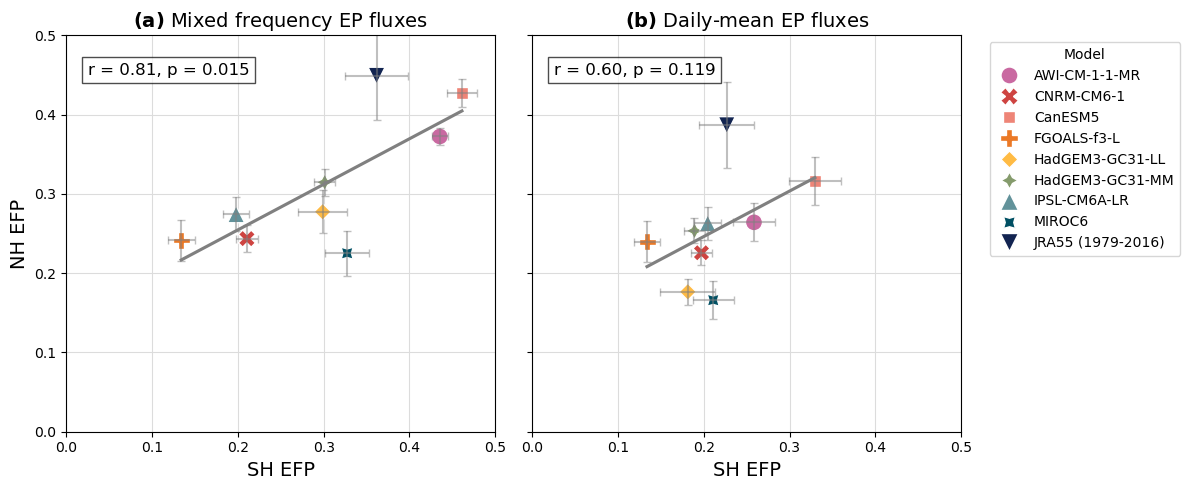

In [141]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

# Panel (a)
sns.regplot(ax=axes[0], data=mixed_freq, x='EFP_SH', y='EFP_NH',
            scatter_kws={'color': 'white'}, line_kws={"color": "gray"}, ci=None)
axes[0].errorbar(
    mixed_freq['EFP_SH'], mixed_freq['EFP_NH'],
    xerr=mixed_freq['EFP_SH_STD'], yerr=mixed_freq['EFP_NH_STD'],
    fmt='none', ecolor='gray', alpha=0.5, capsize=3
)
sns.scatterplot(ax=axes[0], data=mixed_freq, x='EFP_SH', y='EFP_NH',
                hue='Model', style='Model', s=150, palette=palette)

corr_set = mixed_freq[mixed_freq['Model'] != 'JRA55 (1979-2016)']
r, p = sp.stats.pearsonr(x=corr_set['EFP_NH'], y=corr_set['EFP_SH'])
axes[0].text(0.05, 0.9, f"r = {r:.2f}, p = {p:.3f}", transform=axes[0].transAxes,
             bbox=dict(facecolor="white", alpha=0.7), fontsize=12)

axes[0].set_xlabel('SH EFP', fontsize=14)
axes[0].set_ylabel('NH EFP', fontsize=14)
axes[0].set_xlim(0, 0.5)
axes[0].set_ylim(0, 0.5)
axes[0].set_title('$\\bf{(a)}$ Mixed frequency EP fluxes', fontsize=14)
axes[0].legend_.remove()
axes[0].grid(visible=True, color='gainsboro')
axes[0].set_axisbelow(True)

# Panel (b)
sns.regplot(ax=axes[1], data=summary_dict['daily'], x='EFP_SH', y='EFP_NH',
            scatter_kws={'color': 'white'}, line_kws={"color": "gray"}, ci=None)
axes[1].errorbar(
    summary_dict['daily']['EFP_SH'], summary_dict['daily']['EFP_NH'],
    xerr=summary_dict['daily']['EFP_SH_STD'], yerr=summary_dict['daily']['EFP_NH_STD'],
    fmt='none', ecolor='gray', alpha=0.5, capsize=3
)
sns.scatterplot(ax=axes[1], data=summary_dict['daily'], x='EFP_SH', y='EFP_NH',
                hue='Model', style='Model', s=150, palette=palette)

corr_set = summary_dict['daily'][summary_dict['daily']['Model'] != 'JRA55 (1979-2016)']
r, p = sp.stats.pearsonr(x=corr_set['EFP_NH'], y=corr_set['EFP_SH'])
axes[1].text(0.05, 0.9, f"r = {r:.2f}, p = {p:.3f}", transform=axes[1].transAxes,
             bbox=dict(facecolor="white", alpha=0.7), fontsize=12)

axes[1].set_xlabel('SH EFP', fontsize=14)
axes[1].set_ylabel('')  # no label on right subplot
axes[1].set_xlim(0, 0.5)
axes[1].set_ylim(0, 0.5)
axes[1].set_title('$\\bf{(b)}$ Daily-mean EP fluxes', fontsize=14)
axes[1].legend_.remove()
axes[1].grid(visible=True, color='gainsboro')
axes[1].set_axisbelow(True)

# Move legend outside the left panel now
axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Model')

plt.tight_layout()

save_path = '/home/links/ct715/eddy_feedback/chapter1/zz_paper_plots'
# plt.savefig(os.path.join(save_path, 'sub-daily_vs_daily.png'), bbox_inches='tight')
plt.show()